# Курс "Компонентные модели"

## Автор: Харюк Павел, аспирант факультета ВМК МГУ имени М.В. Ломоносова
### Составлено: 2017-2018 гг.

# Занятие 8. Машинное обучение и приложения

## Введение

Данная лекция посвящена основам машинного обучения. Приведены некоторые примеры приложений, иллюстрирующих работу алгоритмов или принципы проведения экспериментов. В машинном обучении принято разделять алгоритмы на обучающиеся с учителем (supervized learning) и без учителя (unsupervised learning). В первом случае обучение (на самом деле, оценка параметров модели) происходит с использованием некоторой внешней информации, во втором случае алгоритм не располагает внешним знанием. Существует и промежуточный вариант - машинное обучение с частичным привлечением учителя. В этой лекции будут рассмотрены задачи регрессии и классификации как примеры задач обучения с учителем и задача кластеризации как пример задачи обучения без учителя. Кроме того, будут даны некоторые сведения о методологии проведения вычислительных экспериментов, в частности, о кросс-валидации.

## Регрессия

Регрессия означает поиск параметров, характеризующих зависимость наблюдаемых величин от предоставленных ранее (регрессоры). Самый простой вид регрессии - линейная: в роли регрессоров выступают некоторые векторы, а наблюдаемая величина подразумевается представимой в виде линейной комбинации регрессоров:

$$y_i = f(x), \quad f(x) = w_0 + w_1 x_1 + \ldots w_n x_n$$

Линейную регрессию можно рассматривать как пример компонентной модели: регрессоры ассоциируются с компонентами, и требуется определить веса $(w_0, w_1, \ldots, w_n)$.

Параметры линейной регрессии обучаются в ходе минимизации того или иного функционала на массиве обучающих данных. Обучающие данные представляются в виде матрицы с осями "номер образца" и "номер признака". Причём регрессоры можно дополнить константным регрессором (сдвигом), отвечающим параметру $w_0$. Таким образом, получаем систему уравнений

$$Xw = y$$

Число образцов обычно не совпадает с числом переменных, поэтому рассматривается обобщённая постановка задачи в виде минимизации эмпирического функционала ошибок:

$$w = \arg \min\limits_{w} \frac{1}{2}\|Xw - y \|^2_F$$

В случае относительно небольшой размерности задачи, можно получить т.н. нормальную систему уравнений (дифференцируем функционал по $w$, приравниваем к нулю):
$$X^T X w = X^T y, \quad w = (X^T X)^{-1} X^T y$$

Однако для масштабных задач $X^T X$ может оказаться слишком сложной подзадачей, и разумно использовать оптимизационные методы. Кроме того, если образцы поступают непрерывно, то требуется постоянное обновление решения, для которого более подходят методы он-лайн обучения.

Относительно значимости того или иного регрессора можно строить разлчные гипотезы и проверять их, использую методы математической статистики. Подробнее об этом можно узнать, например, в курсе [dem].

Пример линейной регрессии приведён ниже. В данном случае использовался набор данных [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). Набор данных содержит 13 регрессоров и целевую переменную в виде стоимости жилья.

(steepest gradient descent) Training error: 0.255
(steepest gradient descent) Test error: 0.302


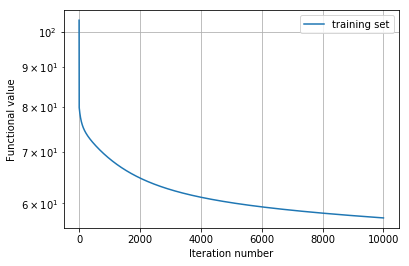

(pseudoinverse) Training error: 0.177
(pseudoinverse) Test error: 0.228


In [70]:
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

maxitnum = 10000
tol = 1e-5

def gradient(w, x, y):
    g = np.dot(x.T, np.dot(x, w) - y)
    return g

def functional(w, x, y):
    f = np.dot(x, w) - y
    f = 0.5*np.linalg.norm(f)
    return f

def alpha_k(g, x):
    alpha = np.sum(g*g)
    Xg = np.dot(x, -g)
    alpha /= np.sum(Xg*Xg)
    return alpha

# загрузка данных
boston = sklearn.datasets.load_boston()
# boston.DESCR # описание данных
X, y = boston.data, boston.target
X = np.hstack([np.ones([y.size, 1]), X])
y = np.reshape(y, [-1, 1])

# разделим на тестовую и обучающую части
sizeY = y.size
batch = None
procTrain = 0.7
sizeTrain = int(np.round(procTrain*sizeY))
indices = np.random.permutation(sizeY)
trainIndex, testIndex = indices[:sizeTrain], indices[sizeTrain:]

Nsamples, Nregressors = X.shape

w = np.zeros([Nregressors, 1])
fv_train = []
for k in xrange(maxitnum):
    if batch is not None:
        indices = trainIndex.copy()
        indices = np.random.permutation(indices)
        indices = indices[:batch]
        g = gradient(w, X[indices], y[indices])
    else:
        g = gradient(w, X[trainIndex], y[trainIndex])
    alpha = alpha_k(g, X[trainIndex])
    wnew = w - alpha*g
    if np.linalg.norm(w-wnew) < tol:
        break
    w = wnew.copy()
    fv_train.append(functional(w, X[trainIndex], y[trainIndex]))
y_pred_train = np.dot(X[trainIndex], w)
print "(steepest gradient descent) Training error: %.3f" % (
    np.linalg.norm(y_pred_train - y[trainIndex]) / np.linalg.norm(y[trainIndex])
)
y_pred_test = np.dot(X[testIndex], w)
print "(steepest gradient descent) Test error: %.3f" % (
    np.linalg.norm(y_pred_test - y[testIndex]) / np.linalg.norm(y[testIndex])
)

plt.semilogy(1+np.arange(len(fv_train)), fv_train, label='training set')
plt.xlabel('Iteration number')
plt.ylabel('Functional value')
plt.grid(True)
plt.legend()
plt.show()

# Решение с помощью псевдообращения
P = np.dot(X[trainIndex].T, X[trainIndex])
P = np.dot(np.linalg.inv(P), X[trainIndex].T)
wP = np.dot(P, y[trainIndex])

y_pred_train = np.dot(X[trainIndex], wP)
print "(pseudoinverse) Training error: %.3f" % (
    np.linalg.norm(y_pred_train - y[trainIndex]) / np.linalg.norm(y[trainIndex])
)
y_pred_test = np.dot(X[testIndex], wP)
print "(pseudoinverse) Test error: %.3f" % (
    np.linalg.norm(y_pred_test - y[testIndex]) / np.linalg.norm(y[testIndex])
)

## Классификация

Задача классификации возникает в случае, когда нужно присвоить входным данным ту или иную метку из некоторого заданного множества меток. Элменты множества меток при этом ассоциированы с классами. 

### Бинарная

Бинарная классификация означает, что множество меток состоит из двух элементов. Рассмотрим один из стандартных алгоритмов бинарной классификации - логистическую регрессию.

Логистическая регрессия представляет собой алгоритм классификации, основанный на нелинейном преобразовании линейной регрессии. Иными словами, логистическая регрессия относится к классу обобщённых линеных моделей (generalized linear models). Параметры линейной регрессии такие же, веса $w = \begin{bmatrix} w_1 & \ldots & w_n \end{bmatrix}^T$, плюс дополнительный пороговый параметр, который преобразует ответ $y(x)$ в бинарный вид:

$$y_{label} = f_{\tau}(y(x)) = \begin{cases} 0, & y(x) \leq \tau\\ 1, & y(x) > \tau \end{cases}, \quad y = \theta(w^T x), \quad \theta(t) = \frac{1}{1 + e^{-t}}$$

По умолчанию значение порога можно считать равным значению логистической функции в нуле, $\tau_0 = \theta(0) = \frac{1}{2}$.

Логистическая функция относится к классу сигмоидных, названных тк по $S$-образной форме их кривых. Такие функции близки к линейным в окрестности нуля, большие же по модулю значения аргумента отображают близко к границам интервала $[a, b]$, в случае логистической функции - $[0, 1]$.

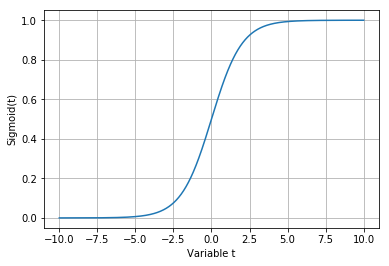

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sigmoid = lambda t: 1./(1+np.exp(-t))
t = np.linspace(-10, 10, 1000)

plt.plot(t, sigmoid(t))
plt.xlabel('Variable t')
plt.ylabel('Sigmoid(t)')
plt.grid(True)
plt.show()

### Мультиклассовая (multiclass classification)

Расширение бинарной классификации подразумевает наличие нескольких классов. При этом для При построении классификатора в не-бинарных задачах можно использовать несколько стратегий классификации, сводящих задачу мультиклассовой классификации к набору бинарных задач. Во-первых, можно рассматривать $N$ задач бинарной классификации (по числу классов), в которых каждый новый образец будет либо отнесён к текущему классу, либо к прочим. 

### Многозначная классификация (multilabel classification)

Отличие данного типа классификации от предыдущего в том, что входным данным требуется присвоить несколько меток одновременно. В качестве примера прикладной задачи, в которой требуется присваивать несколько меток, можно привести качественный анализ газовых смесей.

В этом случае могут помочь вероятностные алгоритмы, ответом которых является вероятность принадлежности к тому или иному классу; выбирать следует, конечно, те классы, вероятность принадлежности к которым максимальна.

Если же алгоритм даёт ответ в виде некоторой метрики, то в случае мультиклассовой классификации ествественно выбирать тот, который даёт наиболее оптимальное значение метрики. В случае же многозначной классификации можно преобразовать выход к "почти вероятностям" спомощью обобщения логистической функции:

$$\text{softmax} (x) = \frac{1}{\sum\limits_i \exp(x_i)} \exp \Big(
\begin{bmatrix}
x_1 & \ldots & x_n
\end{bmatrix}^T \big)
$$



### Метрики качества классификации

Для начала определим ряд вспомогательных величин. Пусть на множестве объектов введено два разбиения, $U = \{U_i\}$ и $V = \{ V_i \}$, и пусть разбиение $U$ соотвествует исходному разбиению, а $V$ получено из ответов классификатора. Для бинарной классификации один из классов назовём "положительным", второй - "отрицательным". В случае небинарной классификации будем работать по стратегии OneVsAll и считать текущий класс положительным, оставшиеся - отрицательным. Рассмотрим 4 величины: верно классифицированные как принадлежащие положительному классу(true positives), верно отнесённые к отрицательному (true negative), неверно отнесённые к отрицательному (false negative), неверно отнесённые к положительному (false positive):

$${TP} = \# \{(a_k, a_l) | a_k, a_l \in U_i, a_k, a_l \in V_j\}$$
$${TN} = \# \{(a_k, a_l) | a_k \in U_{i_1}, a_l \in U_{i_2}, \,  a_k \in V_{j_1}, a_l \in V_{j_2}\}$$
$${FN} = \# \{(a_k, a_l) | a_k, a_l \in U_{i}, a_k \in V_{j_1}, a_l \in V_{j_2}\}$$
$${FP} = \# \{(a_k, a_l) | a_k \in U_{i_1}, a_l \in U_{i_2}, a_k, a_l \in V_{j} \}$$

Точность (accuracy) характеризует долю правильно классифицированных данных:
$${accuracy} = \frac{{TP+TN}}{{TP}+{TN}+{FN}+{FP}}$$

Перевод английского названия "precision" может смутить (тоже ведь точность), однако это две разные точности. Precision является своеобразным аналогом дисперсии, показывает долю релевантных ответов среди всех отнесённых к положительному классу:

$${precision} = \frac{{TP}}{{TP}+{FP}}$$

Полнота (recall) описывает долю релевантных ответов среди всех экземпляров из положительного класса:

$${recall} = \frac{TP}{{TP}+{FN}}$$

Гармоническое среднее между ними позволяет учесть обе характеристики, называется такая метрика $F_1$ мерой:

$$F_1 = 2 \cdot \frac{{precision}\cdot{recall}}{{precision} + {recall}}$$

Кроме приведённых выше стандартных характеристик, существуют и другие методы оценивания качествы работы классификатора. Один из них - ROC-кривая и величина AUC_ROC.

Для начала рассмотрим две дополнительные метрики - специфичность (specificity, false positive rate) и чувствительность (sensitivity, true positive rate):

$${FPR} = \frac{{TP}}{{TP}+{FP}}, \quad {TPR} = \frac{{FP}}{{TP}+{FP}}$$

Далее, предположим, что наш алгоритм классификации имеет внутренний параметр, некоторый порог. Например, у нас есть некоторый биометрический показатель, в зависимости от значения которого принимается решение о том, болен человек или нет. Изменяя порог в пределах от 0 до 1, измерим ${FPR}$ и ${TPR}$ и отложим на графике зависимость 
${TPR} ({FPR})$. Интегральная величина - площадь под ROC-кривой. Используется как метрика качества классификатора. 

## Кластеризация

Является примером задачи, где используется обучение без учителя. В этой задаче требуется сгруппировать объекты в наборе данных в т.н. кластеры, расстояние между объектами внутри которых имеет как можно меньшее значение, а расстояние между кластерами - как можно большее.

### K-means

Один из известных алгоритмов кластеризации. Данный метод решает задачу вида
$$\min \sum\limits_{i=1}^{K}\sum\limits_{x_j \in C_i} \|x_j - \mu_j\|^2_F,$$
где $\mu_j$ - среднее значение элементов, принадлежащих к кластеру $j$. Решение задачи происходит согласно следующему алгоритму:

- случайная инициализация разбиения на кластеры;
- подсчёт среднего в каждом кластере;
- вычисление расстояний для каждого объекта до каждого кластера;
- изменение метки класса на ту, которой соответствует минимальное расстояние до нового среднего
- итеративное повторение всех шагов, кроме первого

Метод ограничен тем, что необходимо знание числа кластеров. Кроме того, алгоритм сходится к некоторому локальному минимуму. Существуют методы определения числа кластеров (см., например, метод на основе коэффициента силуэта) и улучшение первичной инициализации (k-means++), но мы не будем на них останавливаться.

### Спектральная кластеризация

Спектральный алгоритм кластеризации строится на основе анализа симметричной матрицы близости между объектами. При этом близость между ними может определяться различным образом, например:

$$\rho_1(x_i, x_j) = - \|x_i - x_j\|_p^2$$
$$\rho_2(x_i, x_j) = \exp\big(- \alpha \|x_i - x_j\|_p^2\big)$$
$$\rho_3(x_i, x_j) = \frac{(x_i, x_j)}{\|x_i\|_F \|x_j\|_F} $$

Посчитанные попарные близости составляют матрицу близости $A \in \mathbb{R}^{N \times N}$. Этой матрице соответсвует некий граф, вершины которого кодируют объекты, а рёбра имеют веса, описываемые элементами матрицы. Задача кластеризации на языке графов - найти оптимальное разделение графа на подграфы.

Для ненаправленного графа формируется матрица Лапласа $L = D - A$, где матрица $D$ - диагональная, элементы диагонали которой соответсвуют сумме чисел в соответсвующей строке матрицы $A$, то есть, степени вершин графа.
Матрица $L$ симметричная и положительно-определённая, а значит имеет $N$ неотрицательных собственных значений.

Для столбцов матрицы близости $L$ ищется некоторое подпространство меньшей размерности, в котором данные хорошо разделяются. В спектральной кластеризации такое подпространство образуют первые $K$ (число кластеров) собственных векторов (отвечающих наибольшим собственным значениям). Далее кластеризация производится методом К-средних по строкам этих собственных векторов.




### Метрики качества

$$\text{Fowlkes-Mallows score} = \sqrt{\frac{{TP}}{{TP}+{FP}}\frac{{TP}}{{TP}+{FN}}}$$

Представляет собой среднее геометрическое между долей распознанных представителей позитивного класса среди всех отнесённых к нему и долей распознанных представителей позитивного класса среди всех настоящих его представителей.

$$\text{Rand score} = ({TP}+{TN}) / C_N^2 $$

Индекс Рэнда показывает долю правильно распознанных представителей позитивного и негативного классов.

$$\text{Mutual information} = \sum\limits_{i=1}^{I} \sum\limits_{j=1}^{J} P_{ij} \log \frac{P_{ij}}{P_i P_j}, \quad P_{ij} = \frac{|U_i \cap V_j|}{N}, \quad P_{i} = \frac{|U_i|}{N}, \quad V_{j} = \frac{|V_j|}{N}, \quad H(W) = \mathbf{E}[-\log P(W)]$$

Взаимная информация является статистической мерой расстояния от совместного распределения двух величин до произведения их маргинальных распределений. То есть, взаимная информация показывает, насколько независимы в статистическом смысле две величины.

Бывают ситуации, когда следует учитывать поправку индексов на их среднее значение (математическое ожидание): в случае, если оно слишком высоко, то результаты могут оказаться высокими на одном наборе данных при недостаточно высокой работе алгоритма в целом:

$$\text{Rand score}_{\text{adjusted}} = \frac{\text{Rand score} - \mathbf{E}[\text{Rand score}]}{max(\text{Rand score}) - \mathbf{E}[\text{Rand score}]}$$

$$\text{Mutual information}_{\text{adjusted}} = \frac{\text{Mutual information} - \mathbf{E}[\text{Mutual information}]}{max(H(U), H(V)) - \mathbf{E}[\text{Mutual information}]}$$

Заметим, что после введения такой поправки индексы могут принимать отрицательные значения.

## Извлечение признаков

Рассмотренные ранее матричные и тензорные разложения, а также преобразования сигналов могут быть использованы как методы извлечения признаков. В терминах тензорных разложений можно рассматривать также и задачи регрессии.

Здесь приводим несколько работ, в которых используются эти техники имеено в такой роли:

- [Tensor decompositions for feature extraction and classification of high dimensional datasets](http://www.bsp.brain.riken.jp/publications/2010/IEICE_NOLTA_Phan-Cichocki-corr.pdf)
- [Tensor decomposition-based unsupervised feature extraction applied to matrix products for multi-view data processing](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0183933)
- [Tensor decomposition for multiple-tissue gene expression experiments](https://www.nature.com/articles/ng.3624)
- [Independent Component Analysis Applied to Feature Extraction from Colour and Stereo Images](https://www.cs.helsinki.fi/u/ahyvarin/papers/Network00.pdf)
- [Matrix Factorization and Collaborative Filtering](http://acsweb.ucsd.edu/~dklim/mf_presentation.pdf)

## Кросс-валидация

Для проверки достоверности результатов того или иного вычислительного эксперимента, для выбора параметров модели, для выбора самой модели из множества других используются техники кросс-валидации.

Техники кросс-валидации опираются на разбиение выборки. В случае алгоритмов обучения с учителем выборку в первую очередь разделяют на обучающую, на которой производится настройка параметров модели, и тестовую, на которой проверяются результаты обучения. Говорят, что алгоритм имеет хорошую обобщающую способность, если качество работы алгоритма на тестовом и обучающем наборах данных имеет небольшие отличия. В случае, если алгоритм хорошо рботает на обучающей выборке и плохо на тестовой, то говорят, что произошло переобучение.

За процессом обучения можно следить с помощью кривых обучения, откладывая на графике зависимость значения минимизируемого функционала от числа образцов, используемых для обучения. Ниже представлен пример для линейной регрессии.

Отметим также, что для воспроизводимости результатов часто используют параметр, описывающий состояние генератора (псевдо)случайных чисел. Например, в библиотеках numpy и scikit-learn такой параметр называется random_state и принимает целочисленные значения. В примере с обучающими кривыми, в частности, он используется.

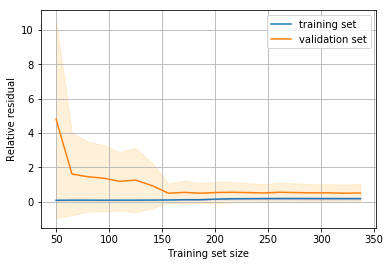

In [26]:
import sklearn.datasets
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# для воспроизводимости экспериментов
random_state = 1245

# загрузка данных
boston = sklearn.datasets.load_boston()
# boston.DESCR # описание данных
X, y = boston.data, boston.target
X = np.hstack([np.ones([y.size, 1]), X])
y = np.reshape(y, [-1, 1])

lin_reg = LinearRegression()

def scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.linalg.norm(y - y_pred) / np.linalg.norm(y)

train_sizes, train_scores, test_scores = learning_curve(
    lin_reg, X, y, scoring=scorer, random_state=random_state,
    train_sizes=np.linspace(0.15, 1.0, 20)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1, ddof=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1, ddof=1)

plt.plot(train_sizes, train_mean, label='training set')
plt.fill_between(
    train_sizes, train_mean - train_std,
    train_mean + train_std, alpha=0.15,
    color="b"
)
plt.plot(train_sizes, test_mean, label='validation set')
plt.fill_between(
    train_sizes, test_mean - test_std,
    test_mean + test_std, alpha=0.15,
    color="orange"
)
plt.xlabel('Training set size')
plt.ylabel('Relative residual')
plt.legend()
plt.grid(True)
plt.show()

В данном случае с ростом объёма обучающей выборки кривая обучения для тестовой выборке сближается с кривой обучения для обучающей выборки, и зазор между кривыми относительно мал. Это свидетельствует о том, что алгоритм обладает обобщающей способностью.

В левой части графика алгоритм точен на обучающей выборке и гораздо хуже работает на тестовой. Такая ситуация свидетельствует о высокой степени переобучения.

## Компромисс смещения и дисперсии

(англ. bias-variance tradeoff)

В алгоритмах машинного обучения существует две краеугольные проблемы: недостаточная точность предсказаний и переобучение. Первая проблема связана с большим смещением предсказания (англ. high bias), то есть, алгоритм даёт неточные ответы. Вторая проблема - алгоритм слишком точно настроился на обучающую выборку и стал чувствителен к изменениям в данных (англ. high variance). Идеальный алгоритм имеет низкое смещение и низкую дисперсию, однако на практике приходится выбирать некотрый компромисс между ними.

Для задачи линейной регрессии в смысле среднеквадратичной ошибки можно построить явные представления этих величин. Исходная задача:

$$\min \textbf{E} \big[ (y - \hat{f}(x))^2\big] = \underbrace{\textbf{E} \big[\hat{f}(x) - f(x)\big]^2}_{\text{bias}} + \underbrace{\textbf{E} \big[(\hat{f}(x))^2\big] - \textbf{E}\big[\hat{f}(x)\big]^2}_{\text{variance}} + \underbrace{\sigma^2}_{\text{noise}} $$

## Способы разбиения выборки

Анализ работы алгоритма часто опирается на некоторую статистику, собранную с нескольких запусков. Простейший способ - разбивать все имеющиеся данные на две непересекающиеся части некоторым случайным образом несколько раз, и усреднить показатели.

Другой способ - последовательно использовать все имеющиеся данные, кроме одного образца, как обучающие, и проводить тестирование на оставшемся образце, последовательно перебирая их все (leave-one-out, LOO). Обобщение такого подхода - k-fold валидация, в которой выборка разделяется на $k$ частей, и каждая из них последовательно используется в роли тестовой. Наконец, можно делать несколько таких разбиений случайным образом (randomized K-fold).

Возвращаясь к компромиссу между дисперсией и смещением: LOO имеет высокое значение дисперсии и низкое значение смещения, $K-fold$ - наоборот, высокое значение смещения и низкое дисперсии. Вместе с тем $k-fold$ валидация более предпочтительна с вычислительной точки зрения. Для практических целей рекомедуют выбирать число подмножеств в разбиении $k$ от 5 до 10 (эмпирический результат).

## Задания.

1) Используем данные digits (sklearn.datasets.load_digits). Введите 10 случайных разбиений данных на 5 частей, последовательно используйте каждую пятую часть в роли тестовых данных, оставшиеся в роле обучающей выборки. Обучите логистическую регрессию без регуляризации, с $l_1$ регуляризацией и $l_2$ регуляризацией на каждом таком наборе данных, получите предсказания на тестовом и на обучающем наборе данных. Для регуляризации рассмотрите значения $C = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]$. Выполните усреднение результатов, отобразите на графиках в зависимости от $C$, выберите лучшие и выведите вместе с результатами без регуляризации. Какой вариант дал лучшие результаты? В каком варианте наибольшее расхождение между результатами на тестовом и обучающем наборах данных? В качестве метрики качества используйте accuracy_score.

2) Возьмите алгоритм, показавший лучшие результаты в прошлом задании, и постройте для него кривые обучения (зависимость качества классификации от увеличения объёма выборки).

3) Теперь посмотрите, насколько хорошо данные кластеризуются. Используйте алгоритм спектральной кластеризации. Сравните индексы точности (adjusted Rand score для кластеризации и accuracy для классификации). Приведите их. Схема кросс-валидации аналогична схеме из задания 1.

# Список материалов

[dem] Б. Демешев. Курс "Эконометрика". URL: https://www.coursera.org/learn/ekonometrika

http://web.itu.edu.tr/sgunduz/courses/verimaden/paper/validity_survey.pdf

https://acutecaretesting.org/en/articles/roc-curves-what-are-they-and-how-are-they-used

http://www.cvl.isy.liu.se/education/graduate/spectral-clustering/

http://sci-hub.tw/10.1017/s1481803500013336

http://cs229.stanford.edu/notes/cs229-notes1.pdf

http://www-bcf.usc.edu/~gareth/ISL/